#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Higher order finite difference methods

## Lagrange Interpolating Polynomials

Suppose we are given function values $u_0, \dotsc, u_n$ at the distinct points $x_0, \dotsc, x_n$ and we would like to build a polynomial of degree $n$ that goes through all these points.  This explicit construction is attributed to Lagrange (though he was not first):

$$ p(x) = \sum_{i=0}^n u_i \prod_{j \ne i} \frac{x - x_j}{x_i - x_j} $$

* What is the degree of this polynomial?
* Why is $p(x_i) = u_i$?
* How expensive (in terms of $n$) is it to evaluate $p(x)$?
* How expensive (in terms of $n$) is it to convert to standard form $p(x) = \sum_{i=0}^n a_i x^i$?
* Can we easily evaluate the derivative $p'(x)$?
* What can go wrong?  Is this formulation numerically stable?

A general derivation of finite difference methods for approximating $p^{(k)}(x)$ using function values $u(x_i)$ is to construct the Lagrange interpolating polynomial $p(x)$ from the function values $u_i = u(x_i)$ and evaluate it or its derivatives at the target point $x$.  We can do this directly from the formula above, but a more linear algebraic approach will turn out to be more reusable.

#### Uniqueness

Is the polynomial $p(x)$ of degree $m$ that interpolates $m+1$ points unique?  Why?

### Vandermonde matrices

We can compute a polynomial

$$ p(x) = c_0 + c_1 x + c_2 x^2 + \dotsb $$

that assumes function values $p(x_i) = u_i$ by solving a linear system with the Vandermonde matrix.

$$ \underbrace{\begin{bmatrix} 1 & x_0 & x_0^2 & \dotsb \\
    1 & x_1 & x_1^2 & \dotsb \\
    1 & x_2 & x_2^2 & \dotsb \\
    \vdots & & & \ddots \end{bmatrix}}_V \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \end{bmatrix} = \begin{bmatrix} u_0 \\ u_1 \\ u_2 \\ \vdots \end{bmatrix} .$$

<IPython.core.display.Javascript object>


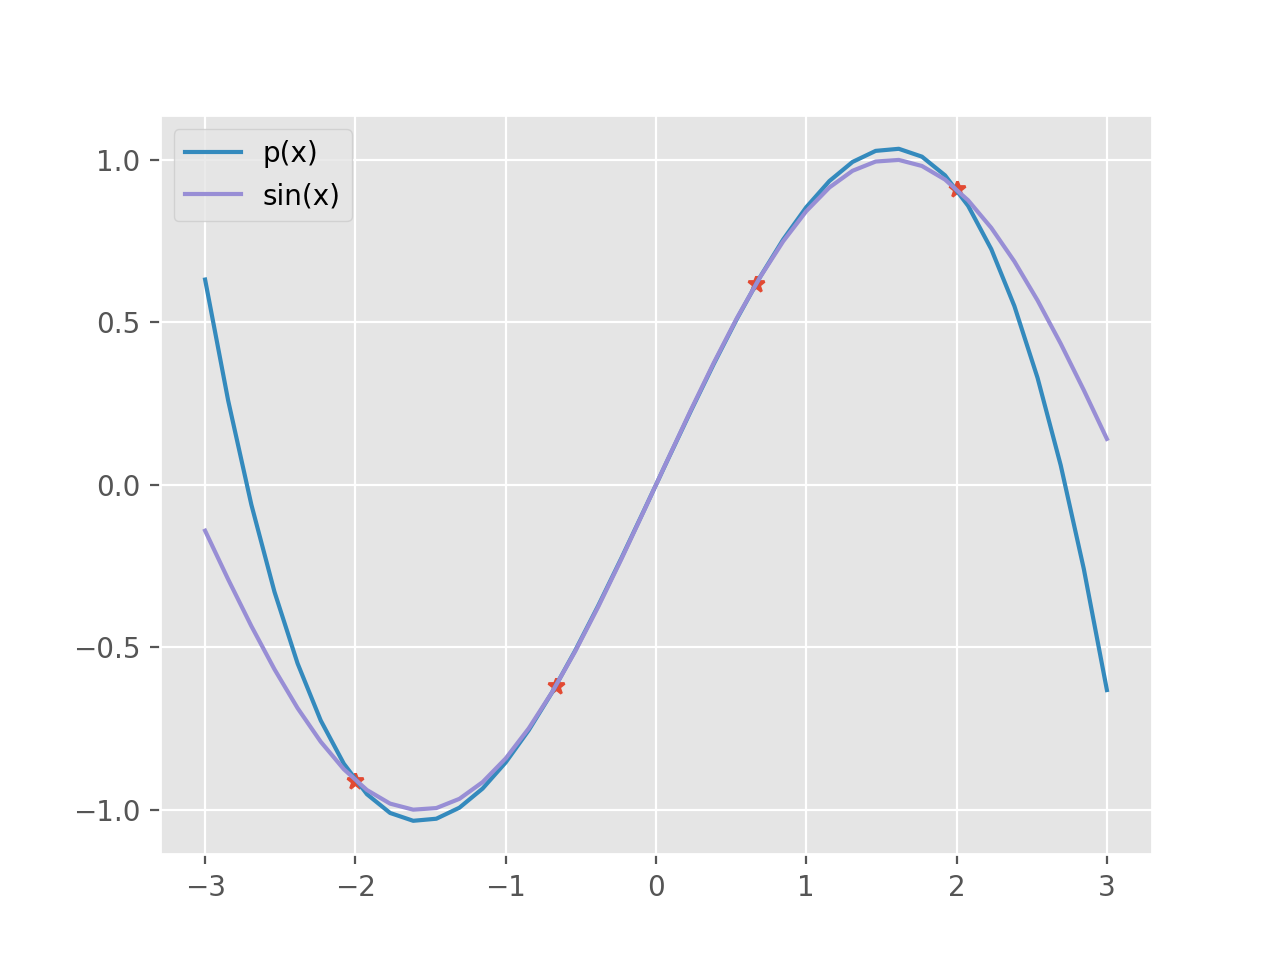

In [8]:
%matplotlib notebook
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

x = numpy.linspace(-2,2,4)
u = numpy.sin(x)
xx = numpy.linspace(-3,3,40)
c = numpy.linalg.solve(numpy.vander(x), u)
pyplot.figure()
pyplot.plot(x, u, '*')
pyplot.plot(xx, numpy.vander(xx, 4).dot(c), label='p(x)')
pyplot.plot(xx, numpy.sin(xx), label='sin(x)')
pyplot.legend(loc='upper left')

Given the coefficients $c = V^{-1} u$, we find

$$ \begin{align} p(0) &= c_0 \\ p'(0) &= c_1 \\ p''(0) &= c_2 \cdot 2! \\ p^{(k)}(0) &= c_k \cdot k! . \end{align} $$

To compute the stencil coefficients $s_i^0$ for interpolation to $x=0$,
$$ p(0) = s_0^0 u_0 + s_1^0 u_1 + \dotsb = \sum_i s_i^0 u_i $$
we can write
$$ p(0) = e_0^T \underbrace{V^{-1} u}_c = \underbrace{e_0^T V^{-1}}_{(s^0)^T} u $$
where $e_0$ is the first column of the identity.  Evidently $s^0$ can also be expressed as
$$ s^0 = V^{-T} e_0 . $$
We can compute stencil coefficients for any order derivative $p^{(k)}(0) = (s^k)^T u$ by solving the linear system
$$ s^k = V^{-T} e_k \cdot k! . $$
Alternatively, invert the Vandermonde matrix $V$ and scale row $k$ of $V^{-1}$ by $k!$.

[[ 0.   1.   0. ]
 [-0.5  0.   0.5]
 [ 1.  -2.   1. ]]


<IPython.core.display.Javascript object>


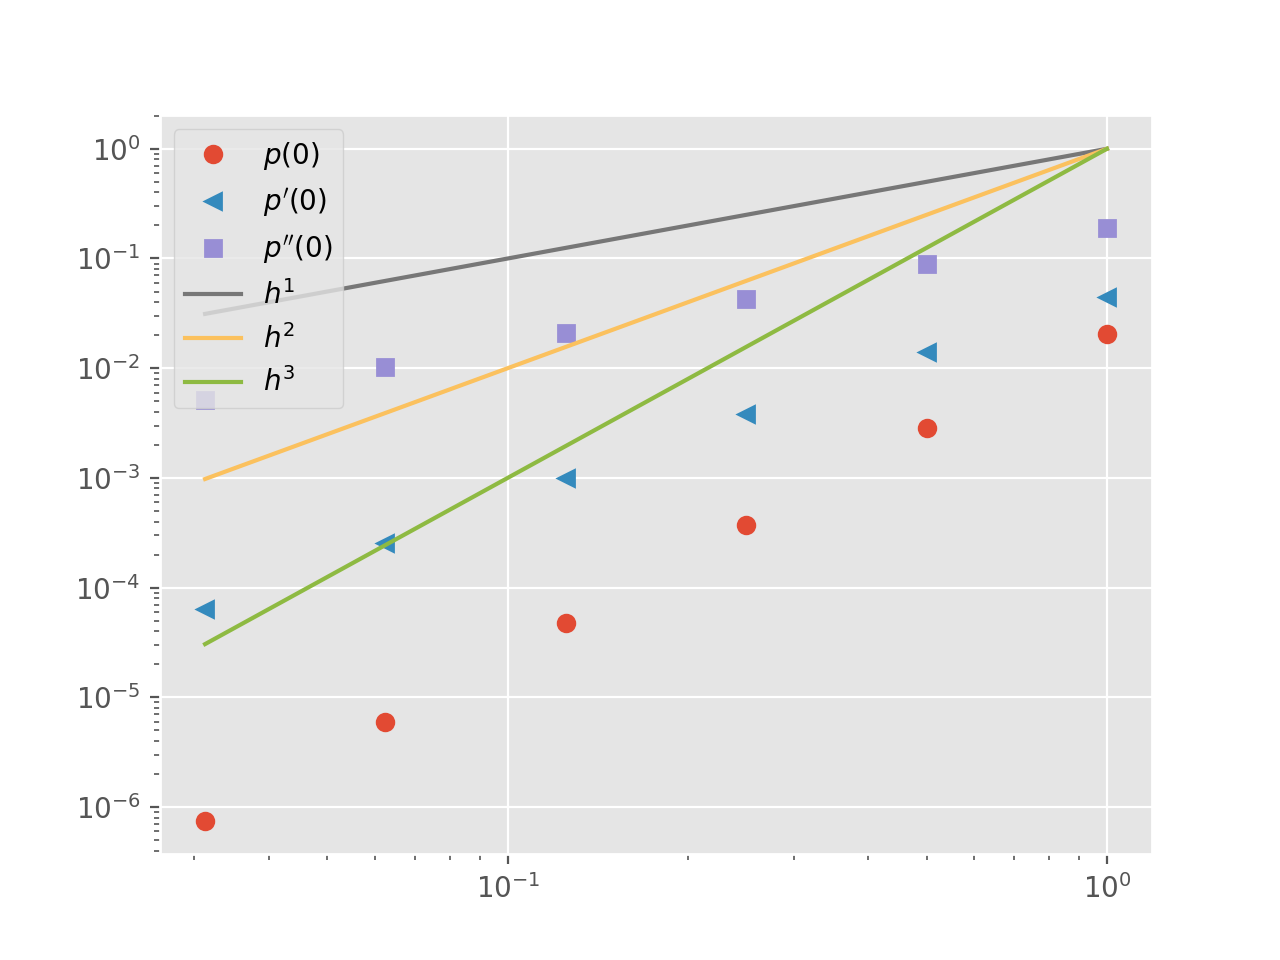

In [282]:
def fdstencil(z, x):
    x = numpy.array(x)
    V = numpy.vander(x - z, increasing=True)
    scaling = numpy.array([numpy.math.factorial(i) for i in range(len(x))])
    return (numpy.linalg.inv(V).T * scaling).T

x = numpy.linspace(-1,1,3)
S = fdstencil(0, x)
print(S)

hs = 2.**(-numpy.arange(6))
errors = numpy.zeros((3,len(hs)))
for i,h in enumerate(hs):
    z = 1 + .3*h
    S = fdstencil(z, 1+x*h)
    u = numpy.sin(1+x*h)
    errors[:,i] = S[:3].dot(u) - numpy.array([numpy.sin(z), numpy.cos(z), -numpy.sin(z)])

pyplot.figure()
pyplot.loglog(hs, numpy.abs(errors[0]), 'o', label="$p(0)$")
pyplot.loglog(hs, numpy.abs(errors[1]), '<', label="$p'(0)$")
pyplot.loglog(hs, numpy.abs(errors[2]), 's', label="$p''(0)$")
for k in (1,2,3):
    pyplot.loglog(hs, hs**k, label='$h^{%d}$' % k)
pyplot.legend(loc='upper left')

### Notes on accuracy

* When using three points, we fit a polynomial of degree 2.  The leading error term for interpolation $p(0)$ is thus $O(h^3)$.
* Each derivative gives up one order of accuracy, therefore differencing to a general (non-centered or non-uniform grid) point is $O(h^2)$ for the first derivative and $O(h)$ for the second derivative.
* Centered differences on uniform grids can provide cancelation, raising the order of accuracy by one.  So our standard 3-point centered second derivative is $O(h^2)$ as we have seen in the Taylor analysis and numerically.
* The Vandermonde matrix is notoriously ill-conditioned when using many points.  For such cases, we recommend using a more numerically stable method from [Fornberg](https://doi.org/10.1137/S0036144596322507).

In [306]:
-fdstencil(0, numpy.linspace(-1,1,3))[2]

array([-1.,  2., -1.])

### Solving BVPs

This `fdstencil` gives us a way to compute derivatives of arbitrary accuracy on arbitrary grids.  We will need to use uncentered rules near boundaries, usually with more points to maintain order of accuracy.  This will usually cost us symmetry.  Implementation of boundary conditions is the bane of high order finite difference methods.

### Discretization stability measures: $h$-ellipticity

Consider the test function $\phi(\theta, x) = e^{i\theta x}$ and apply the difference stencil centered at an arbitrary point $x$ with element size $h=1$:

$$ \begin{bmatrix} -1 & 2 & -1 \end{bmatrix} \begin{bmatrix} e^{-i \theta (x - 1)} \\ e^{i \theta x} \\ e{i \theta (x+1)} \end{bmatrix}
= \big( 2 - (e^{i\theta} + e^{-i\theta}) \big) e^{i\theta x}= 2 (1 - \cos \theta) e^{i \theta x} . $$

Evidently $\phi(\theta,x) = e^{i \theta x}$ is an eigenfunction of the discrete differencing operator on an infinite grid and the corresponding eigenvalue is
$$ L(\theta) = 2 (1 - \cos \theta), $$
also known as the "symbol" of the operator.  That $\phi(\theta,x)$ is an eigenfunction of the discrete differencing formula will generally be true for uniform grids.

The highest frequency that is distinguishable using this stencil is $\theta_{\max} = \pi$ which results in a wave at the Nyquist frequency.  If a higher frequency wave is sampled onto this grid, it will be aliased back into the interval $[-\pi, \pi)$.

<IPython.core.display.Javascript object>


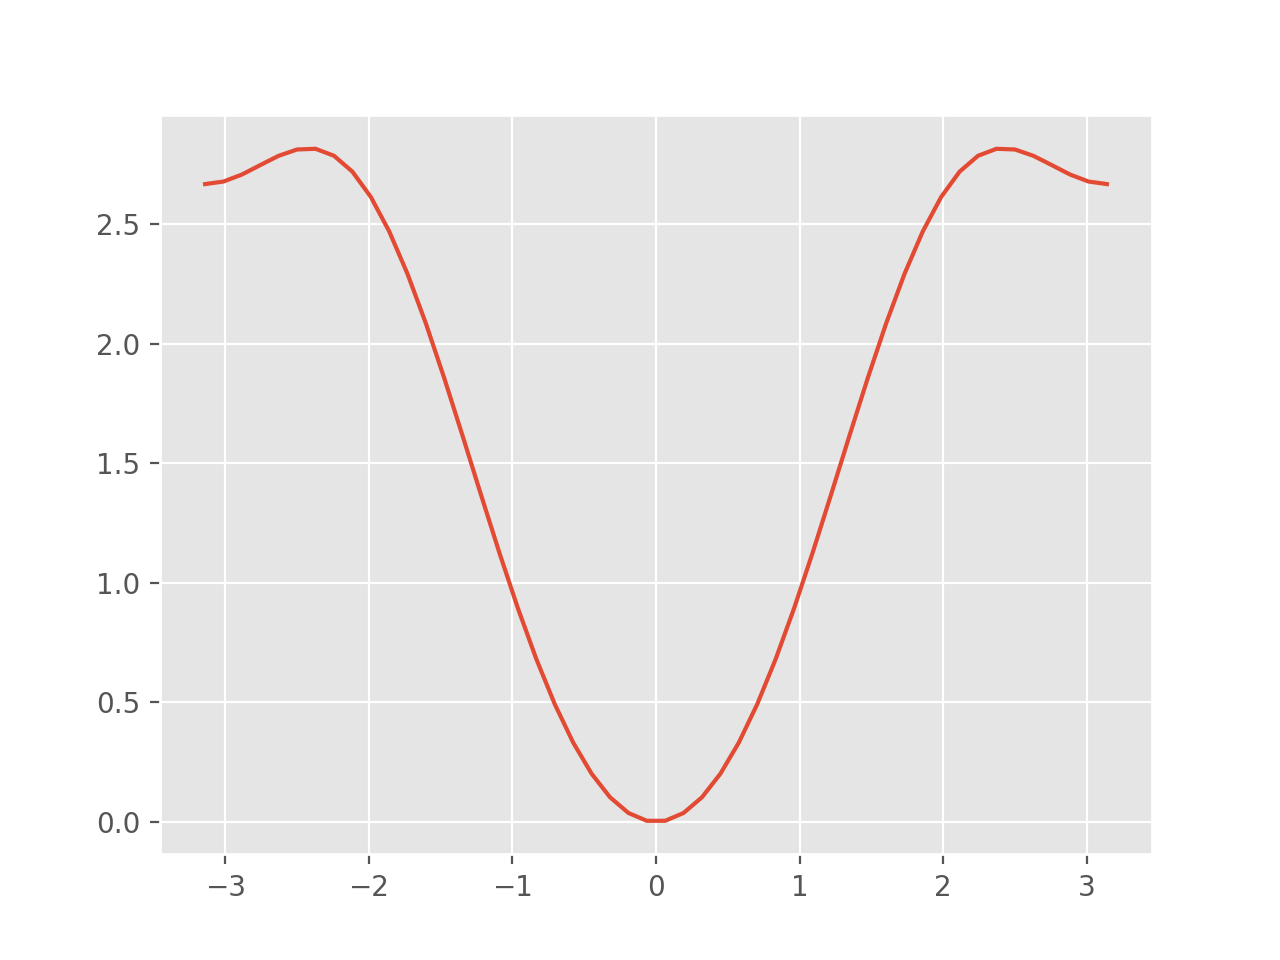

In [305]:
x = numpy.linspace(-1, 3, 5)
s2 = -fdstencil(0, x)[2]
theta = numpy.linspace(-numpy.pi, numpy.pi)
phi = numpy.exp(1j*numpy.outer(x, theta))
pyplot.figure()
pyplot.plot(theta, numpy.abs(s2.dot(phi)))

A measure of internal stability known as $h$-ellipticity is defined by

$$ E^h(L) = \frac{\min_{\pi/2 \le |\theta| \le \pi} L(\theta)}{\max_{|\theta| \le \pi} L(\theta)} . $$

* What is $E^h(L)$ for the second order "version 2" stencil?
* How about for uncentered formulas and higher order?

### Spectral collocation

Suppose that instead of using only a fixed number of neighbors in our differencing stencil, we use all points in the domain?

<IPython.core.display.Javascript object>


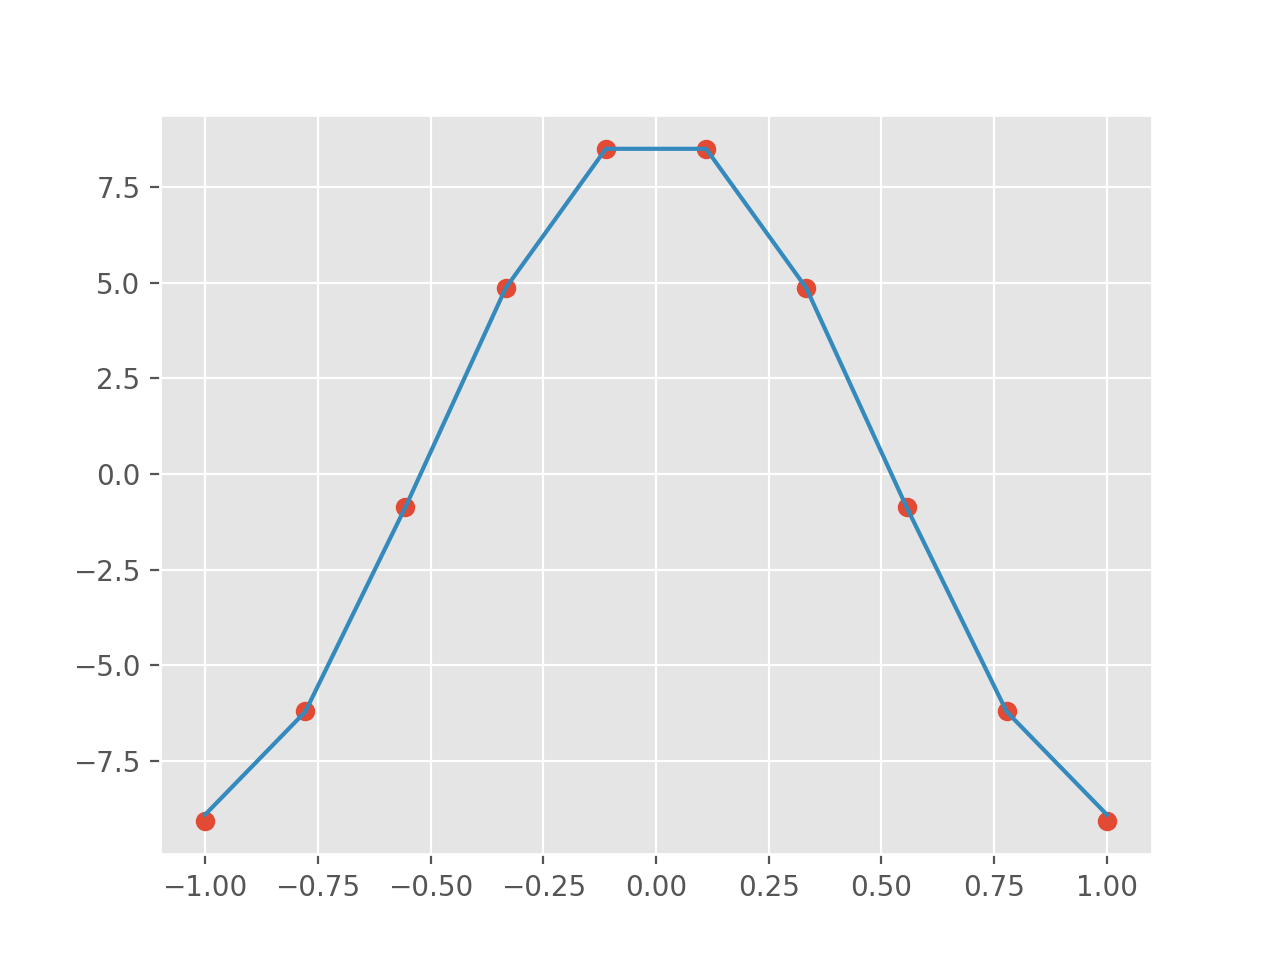

In [315]:
n = 10
x = numpy.linspace(-1, 1, n)
L = numpy.zeros((n,n))
for i in range(n):
    L[i] = -fdstencil(x[i], x)[2]

u = numpy.cos(3*x)
pyplot.figure()
pyplot.plot(x, L.dot(u), 'o')
pyplot.plot(x, 9*u)

We are suffering from two problems here.  The first is that the monomial basis is very ill-conditioned when using many terms.  This is true as continuous functions, not just when sampled onto a particular grid.

<IPython.core.display.Javascript object>


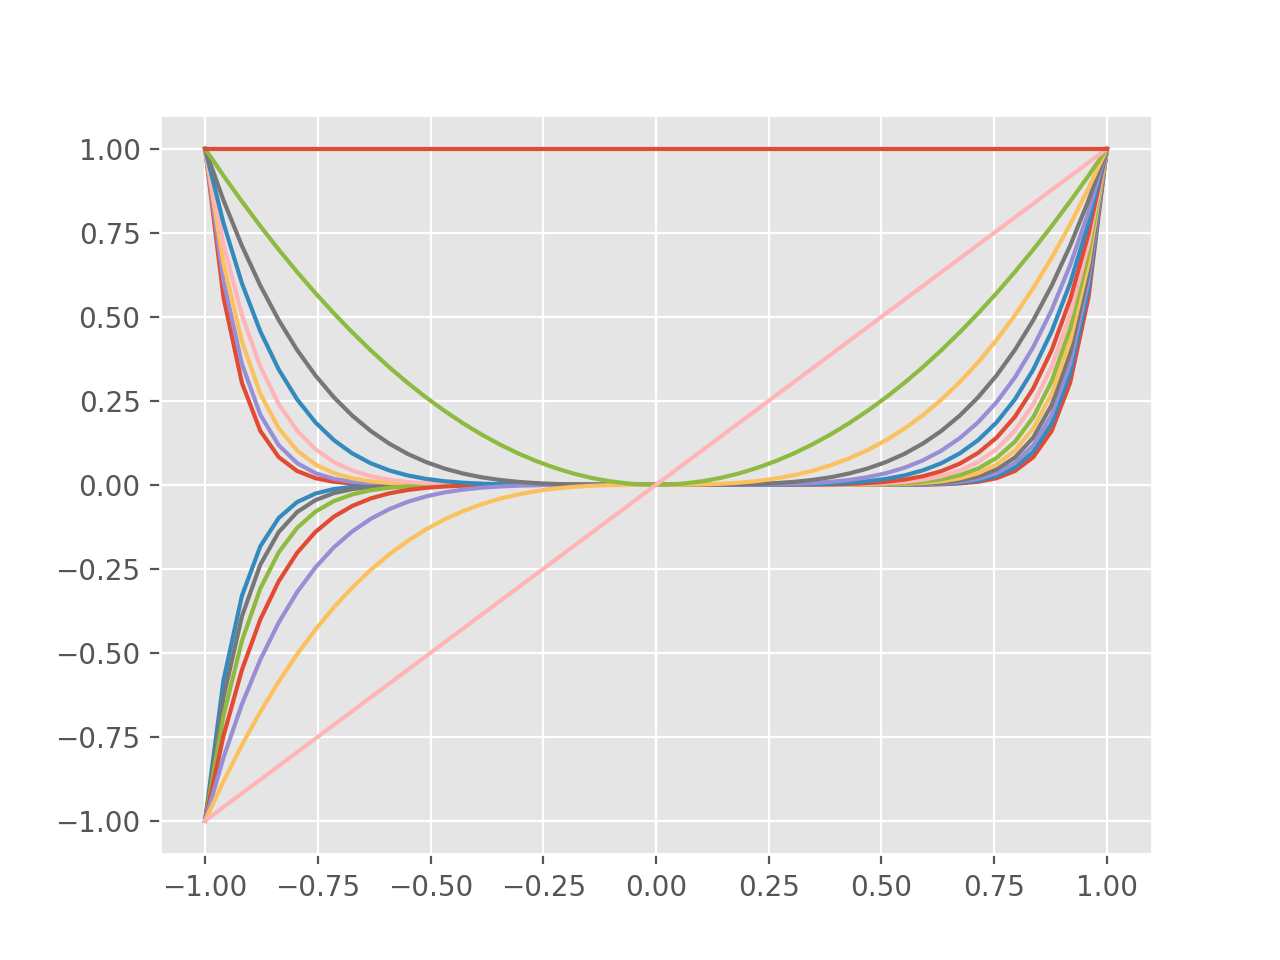

95176.859518572863

In [207]:
x = numpy.linspace(-1, 1)
pyplot.figure()
V = numpy.vander(x, 15)
pyplot.plot(x, V)
numpy.linalg.cond(V)

### Chebyshev polynomials

Define $$ T_n(x) = \cos (n \arccos(x)) .$$
This turns out to be a polynomial, though it may not be obvious why.
Recall $$ \cos(a + b) = \cos a \cos b - \sin a \sin b .$$
Let $y = \arccos x$ and check
$$ \begin{split}
    T_{n+1}(x) &= \cos (n+1) y = \cos ny \cos y - \sin ny \sin y \\
    T_{n-1}(x) &= \cos (n-1) y = \cos ny \cos y + \sin ny \sin y
\end{split}$$
Adding these together produces a similar recurrence:
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$
which we can also implement in code

<IPython.core.display.Javascript object>


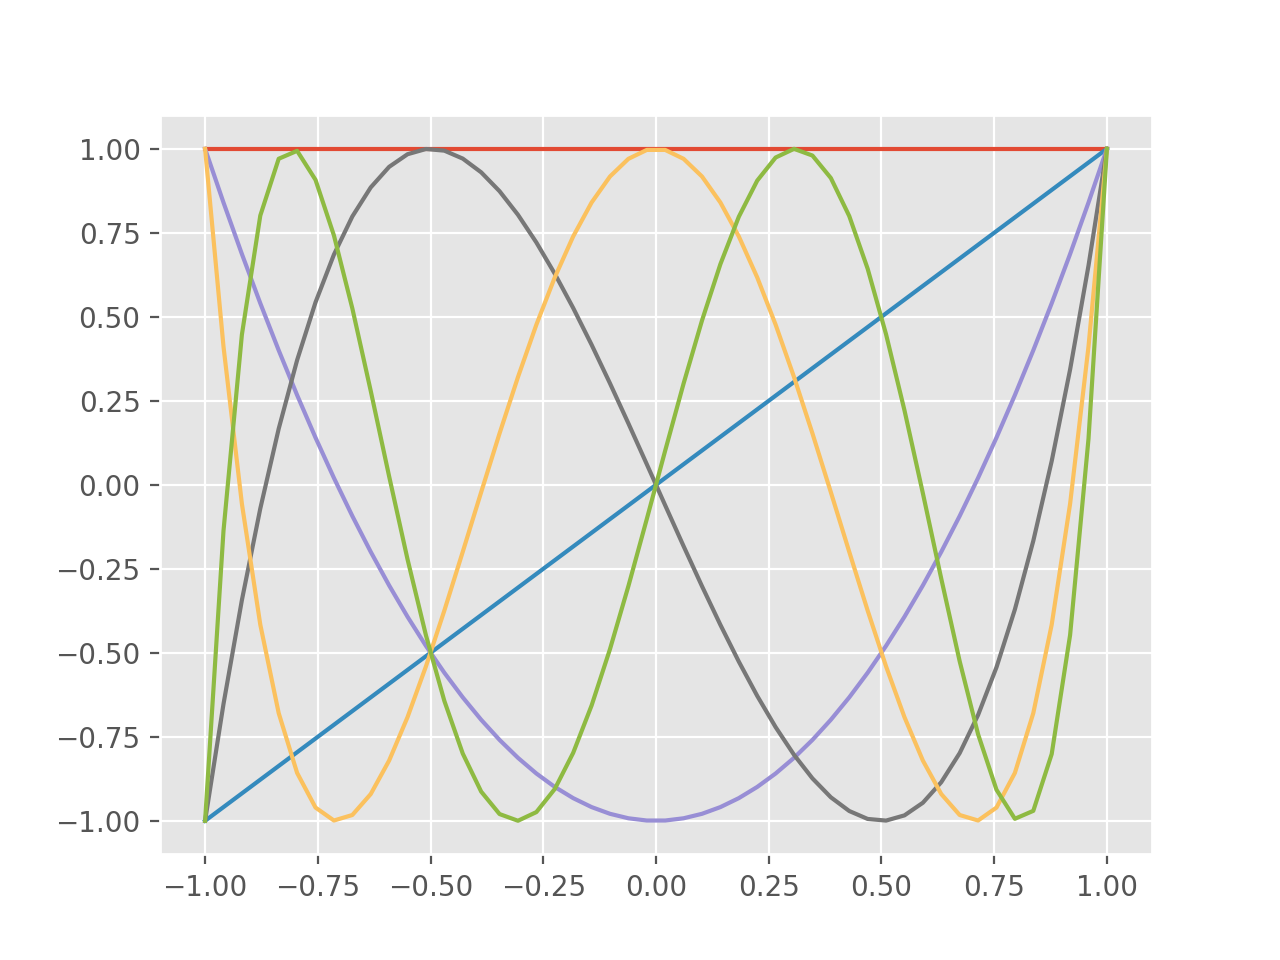

2.4053255255130992

In [317]:
def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = numpy.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(2,n):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
    return T

x = numpy.linspace(-1, 1)
pyplot.figure()
V = vander_chebyshev(x, 6)
pyplot.plot(x, V)
numpy.linalg.cond(V)

<IPython.core.display.Javascript object>


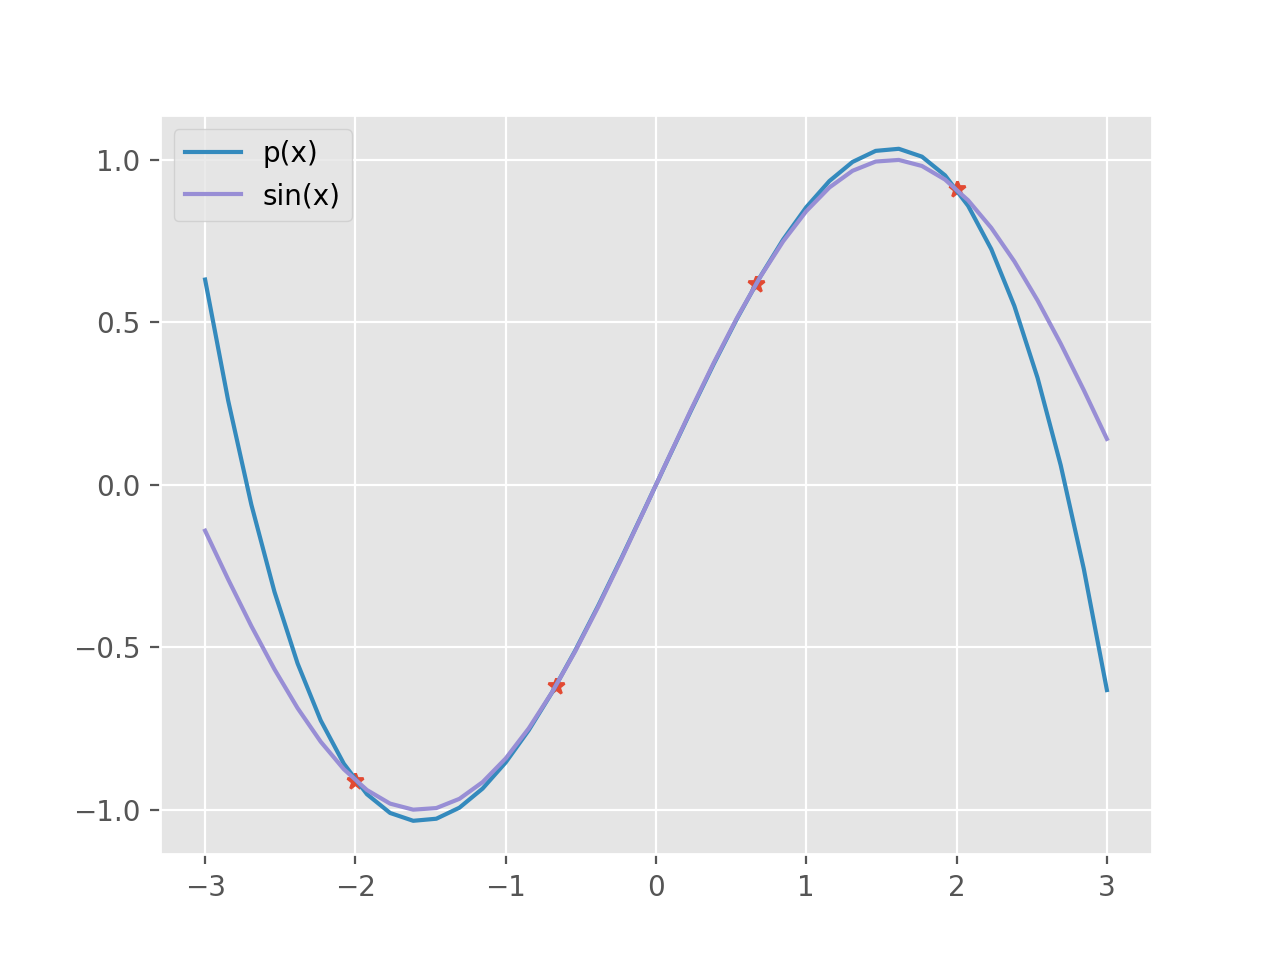

In [217]:
# We can use the Chebyshev basis for interpolation
x = numpy.linspace(-2, 2, 4)
u = numpy.sin(x)
c = numpy.linalg.solve(vander_chebyshev(x), u)
pyplot.figure()
pyplot.plot(x, u, '*')
pyplot.plot(xx, vander_chebyshev(xx, 4).dot(c), label='p(x)')
pyplot.plot(xx, numpy.sin(xx), label='sin(x)')
pyplot.legend(loc='upper left')

We can also differentiate Chebyshev polynomials using the recurrence

$$ T_n'(x) = n \big(2 T_{n-1}(x) + T_{n-2}'(x) \big) . $$

<IPython.core.display.Javascript object>


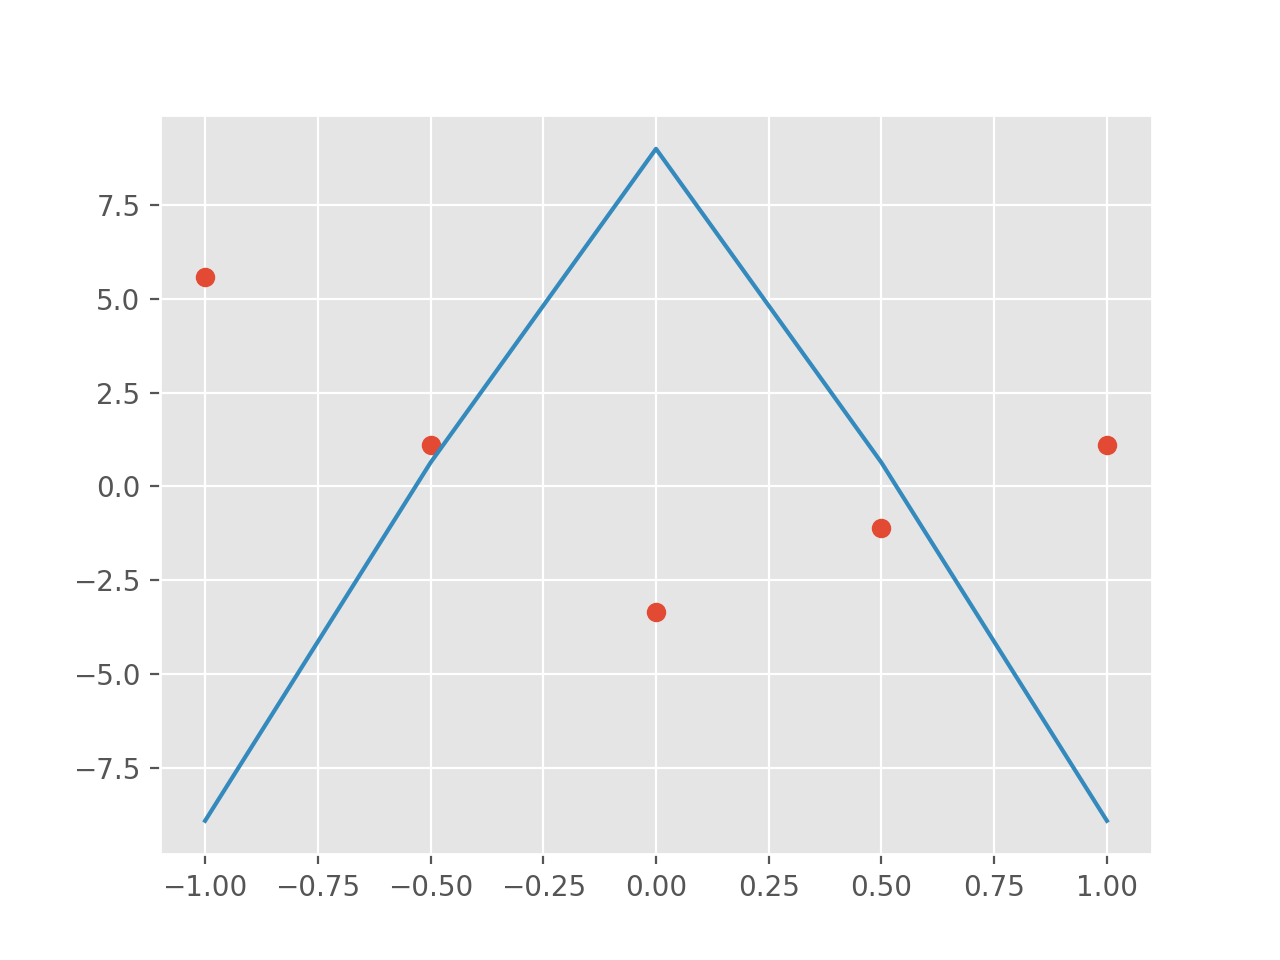

In [319]:
def chebeval(c, z):
    z = numpy.array([z])
    Tz = vander_chebyshev(z, len(c))
    dTz = numpy.zeros_like(Tz)
    dTz[:,1] = 1
    for n in range(2,len(c)):
        dTz[:,n] = n * (2*Tz[:,n-1] + dTz[:,n-2])
    ddTz = numpy.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,len(c)):
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2])
    return numpy.vstack((Tz.dot(c), dTz.dot(c), ddTz.dot(c)))

n = 5
x = numpy.linspace(-1, 1, n)
Tinv = numpy.linalg.inv(vander_chebyshev(x))
L = numpy.zeros((n,n))
for i in range(n):
    L[i] = -chebeval(Tinv[i], x[i])[2]

u = numpy.cos(3*x)
pyplot.figure()
pyplot.plot(x, L.dot(u), 'o')
pyplot.plot(x, 9*u)